<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>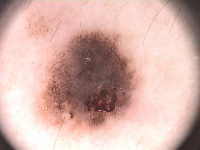</td><td>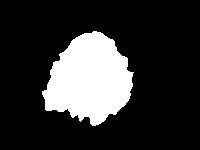</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time

from torch.utils.data import DataLoader

import patoolib
import pickle

import matplotlib.pyplot as plt
from IPython.display import clear_output

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,6)

In [2]:
patoolib.extract_archive("PH2Dataset.rar")

patool: Extracting PH2Dataset.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\rosas\JUPYTER\PYTORCH\PH2Dataset.rar
patool:     with cwd=.\Unpack_ht3xy9_2
patool: ... PH2Dataset.rar extracted to `PH2Dataset27' (local file exists).


'PH2Dataset27'

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

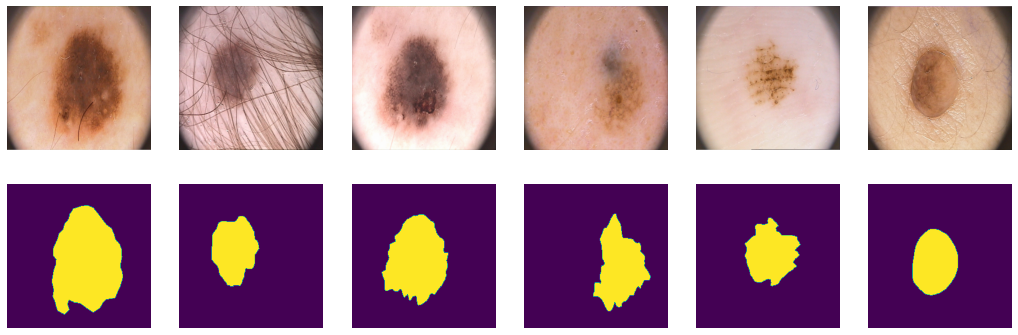

In [6]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


In [10]:
set_seed(42)

#### PyTorch DataLoader

In [11]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

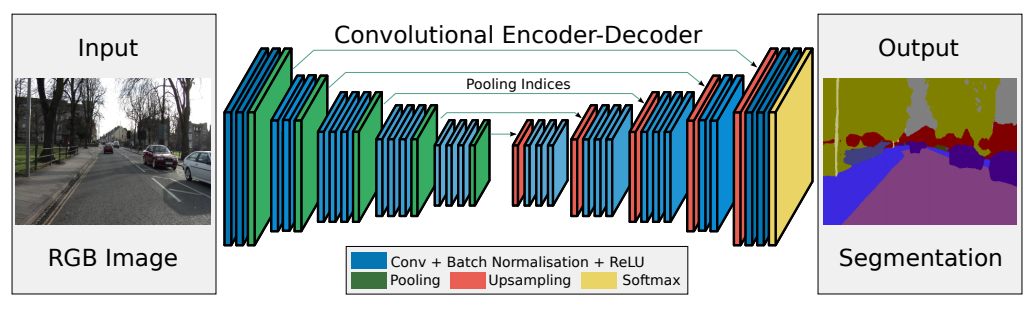

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
# Создадим вспомогоательные функции для слоев моделей:

#double 3x3 convolution 
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True)
    )
    return conv

#triple 3x3 convolution 
def triple_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True)
    )
    return conv

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = dual_conv(3, 64)
        self.enc_conv1 = dual_conv(64, 128)
        self.enc_conv2 = triple_conv(128, 256)
        self.enc_conv3 = triple_conv(256, 512)
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_enc_conv = triple_conv(512, 1024)
        #self.bottleneck_maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck_upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.bottleneck_dec_conv = dual_conv(512,512)


        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv0 = triple_conv(256,256)
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv1 = triple_conv(128,128)
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = dual_conv(64,64)
        self.upsample3 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False),
                                       nn.BatchNorm2d(1), nn.ReLU(inplace= True),
                                       nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False) 
                                      ) # no activation
  
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0 = self.maxpool_2x2(e0)                           
        e1 = self.enc_conv1(e0)
        e1 = self.maxpool_2x2(e1)                      
        e2 = self.enc_conv2(e1)
        e2 = self.maxpool_2x2(e2)                           
        e3 = self.enc_conv3(e2)
        e3 = self.maxpool_2x2(e3)

        # bottleneck
        b = self.bottleneck_enc_conv(e3)
        b = self.maxpool_2x2(b)
        b = self.bottleneck_upsample(b) 
        b = self.bottleneck_dec_conv(b)  

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)  
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(d2) 
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(d3)
        # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_pred, y_real):
    y_mod = torch.abs(y_pred)
    return torch.mean(torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_real*y_pred + torch.log(1 + torch.exp(-y_mod)))
    # please don't use nn.BCELoss. write it from scratch

In [18]:
# проверка
bce_loss(torch.rand(10, 1, 100, 100), torch.rand(10, 1, 100, 100)).shape

torch.Size([])

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, PATH):
    scheduler = lr_scheduler.ReduceLROnPlateau(opt, 'min')  # добавил чедулер
    
    train_loss = []
    val_loss = []
    val_score = []
    score_max = 0
    epoch_for_score_max = 0
    
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        model = model.to(device)
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) # data to device

            opt.zero_grad() # set parameter gradients to zero

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch ) # forward-pass
            
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        scheduler.step(loss)
        train_loss.append(avg_loss)
        
        toc = time()
        print(f"lr={opt.param_groups[0]['lr']}")

        # show intermediate results
        model.eval()  # testing mode
        X_val, Y_val  = X_val.to(device), Y_val.to(device) # data to device
        
        with torch.set_grad_enabled(False):
            Y_pred_v = model(X_val) 
            loss_v = loss_fn(Y_pred_v, Y_val) 
            
        Y_hat =  Y_pred_v.sigmoid().round().detach().to('cpu') # detach and put into cpu    
        X_val = X_val.to('cpu')
        Y_val = Y_val.to('cpu')
        val_loss.append(loss_v.item())
        
        score = score_model(model, iou_pytorch, data_val)
        
        if score > score_max:
            score_max = score
            epoch_for_score_max = epoch
            best_model = model.state_dict()
        
        val_score.append(score)
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0].round(), cmap='gray')
            plt.title('Label')
            plt.axis('off')
            
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        print(f"lr={opt.param_groups[0]['lr']}")
        # print(f"train_loss={train_loss}")
        # print(f"val_loss={val_loss}")
        # print(f"val_score={val_score}")
        print(f"score_max={score_max}")
        print(f"epoch_for_score_max={epoch_for_score_max}")    
    torch.save(best_model, PATH)
    
    return train_loss, val_loss, val_score, score_max, epoch_for_score_max  

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    model.eval()# testing mode
    with torch.no_grad():
        for X_batch, Y_batch in data:
            X_batch = X_batch.to(device)
            Y_pred = model(X_batch).to(device)
            Y_pred = torch.sigmoid(Y_pred).round()
        return np.array(Y_pred.to('cpu')), X_batch.to('cpu'), Y_batch

In [22]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    #model = model#.to('cpu')
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to('cuda')
            Y_label = Y_label#.to('cuda')
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred).round().to('cpu')
            scores += metric(Y_pred, Y_label).mean().item()
        return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
#model = SegNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_segnet_bce.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#bce_segnet_train = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val, PATH)

In [49]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
#with open('bce_segnet_train.pickle', 'wb') as f:
    #pickle.dump(bce_segnet_train, f)

In [90]:
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('bce_segnet_train.pickle', 'rb') as f:
    bce_segnet_train = pickle.load(f)

In [91]:
# Загрузим сохраненную лучшую модель 
model_segnet_bce = SegNet()
model_segnet_bce = model_segnet_bce.to(device)
model_segnet_bce.load_state_dict(torch.load("state_dict_best_model_segnet_bce.pt"))

<All keys matched successfully>

In [92]:
train_loss, val_loss, val_score, score_max, epoch_for_score_max = bce_segnet_train

In [93]:
# Результаты score на валидационных данных
score_model(model_segnet_bce, iou_pytorch, data_val)

0.7544209957122803

In [94]:
# Результаты score на тестовых данных
score_model(model_segnet_bce, iou_pytorch, data_ts)

0.7823149859905243

In [95]:
# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

epoch_for_score_max=50


In [96]:
# Визуализируем прдсказания по тестовым данным
YYY = predict(model_segnet_bce, data_ts)

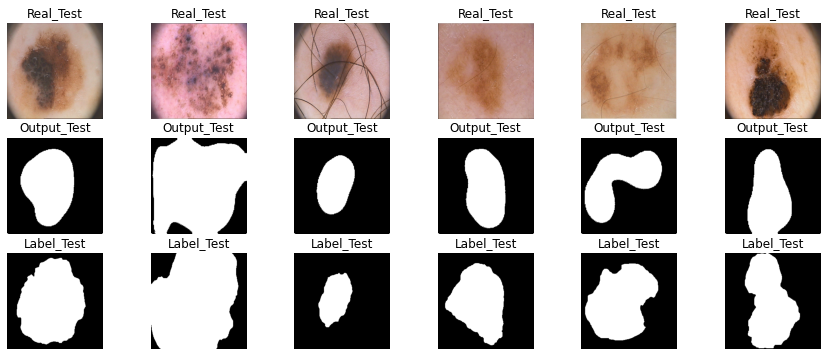

In [97]:
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')
    
   

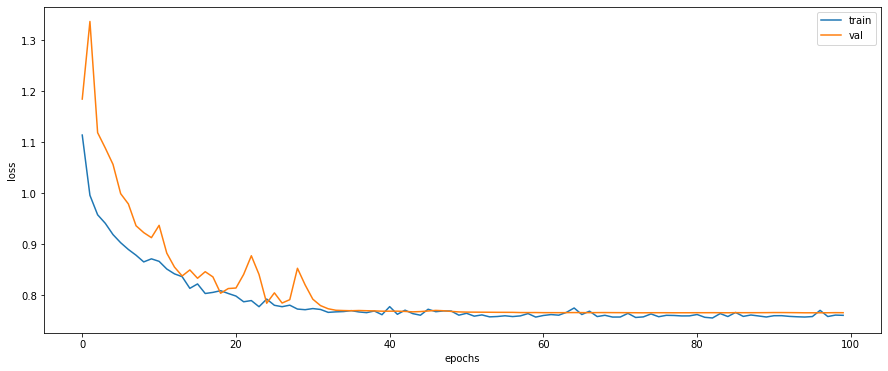

In [52]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

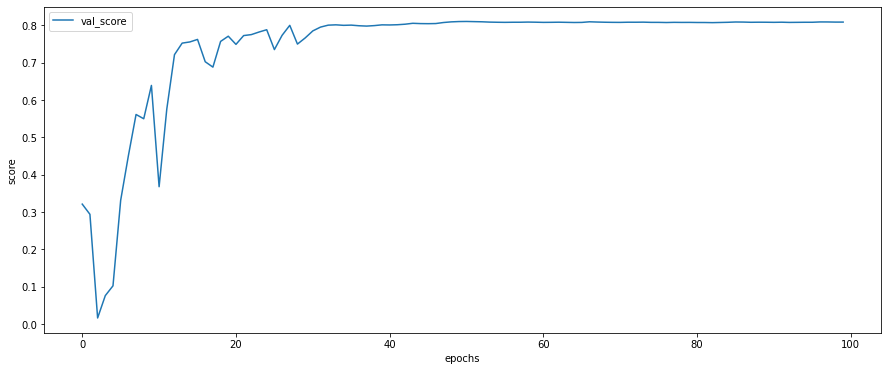

In [54]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real):
    num = 2 * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred + y_real) 
    res = 1 - (num + 1) / (den + 1)
    return res 

Проводим тестирование:

In [55]:
#model = SegNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_segnet_dice.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#dice_segnet_train = train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val, PATH)

In [56]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
#with open('dice_segnet_train.pickle', 'wb') as f:
    #pickle.dump(dice_segnet_train, f)

In [57]:
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('dice_segnet_train.pickle', 'rb') as f:
    dice_segnet_train = pickle.load(f)

In [58]:
# Загрузим сохраненную лучшую модель 
model_segnet_dice = SegNet()
model_segnet_dice = model_segnet_dice.to(device)
model_segnet_dice.load_state_dict(torch.load("state_dict_best_model_segnet_dice.pt"))

<All keys matched successfully>

In [59]:
train_loss, val_loss, val_score, score_max, epoch_for_score_max = dice_segnet_train

In [60]:
# Результаты score на валидационных данных
score_model(model_segnet_dice, iou_pytorch, data_val)

0.7785684168338776

In [61]:
# Результаты score на тестовых данных
score_model(model_segnet_dice, iou_pytorch, data_ts)

0.8009510636329651

In [62]:
# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

epoch_for_score_max=75


In [63]:
# Визуализируем прдсказания по тестовым данным
YYY = predict(model_segnet_dice, data_ts)

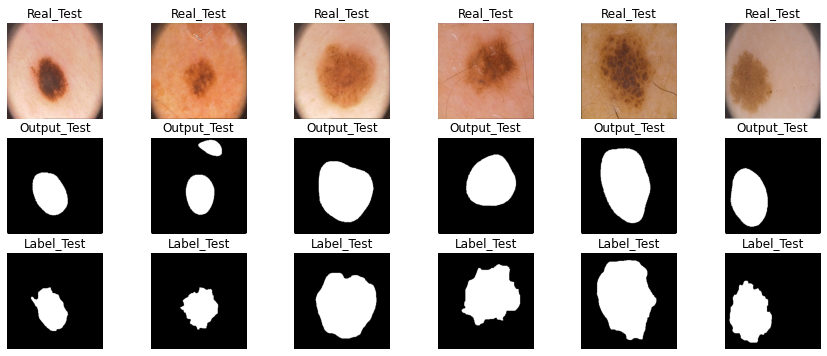

In [64]:
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

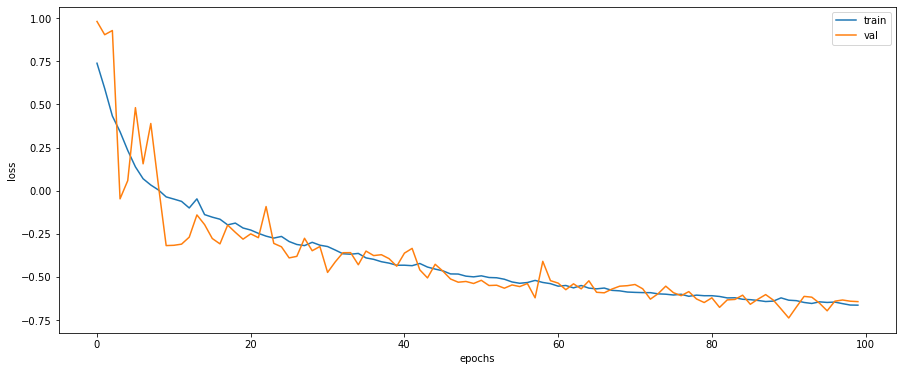

In [65]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

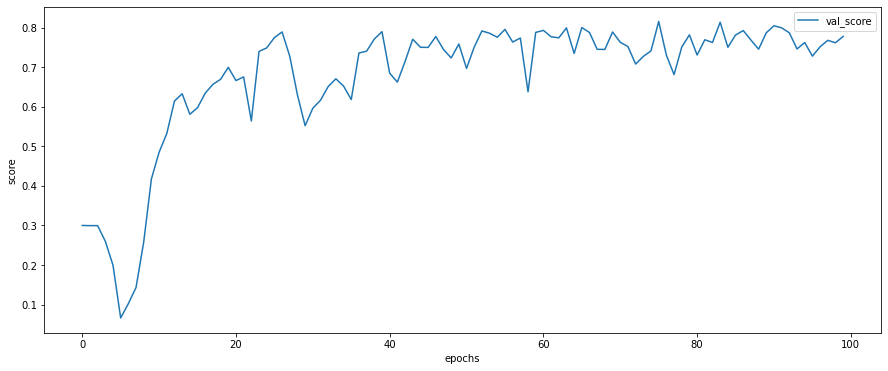

In [66]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [67]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    pt = torch.exp(-bce_loss(y_real, y_pred))
    focal_loss = (1-pt)**gamma * bce_loss(y_real, y_pred)
    return focal_loss.mean()


In [ ]:
#model = SegNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_segnet_focal.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#focal_segnet_train = train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val, PATH)

In [ ]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
#with open('focal_segnet_train.pickle', 'wb') as f:
    #pickle.dump(focal_segnet_train, f)

In [68]:
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('focal_segnet_train.pickle', 'rb') as f:
    focal_segnet_train = pickle.load(f)

In [69]:
# Загрузим сохраненную лучшую модель 
model_segnet_focal = SegNet()
model_segnet_focal = model_segnet_focal.to(device)
model_segnet_focal.load_state_dict(torch.load("state_dict_best_model_segnet_focal.pt"))

<All keys matched successfully>

In [70]:
train_loss, val_loss, val_score, score_max, epoch_for_score_max = focal_segnet_train

In [71]:
# Результаты score на валидационных данных
score_model(model_segnet_focal, iou_pytorch, data_val)

0.8418045938014984

In [72]:
# Результаты score на тестовых данных
score_model(model_segnet_focal, iou_pytorch, data_ts)

0.848107784986496

In [73]:
# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

epoch_for_score_max=99


In [74]:
# Визуализируем прдсказания по тестовым данным
YYY = predict(model_segnet_focal, data_ts)

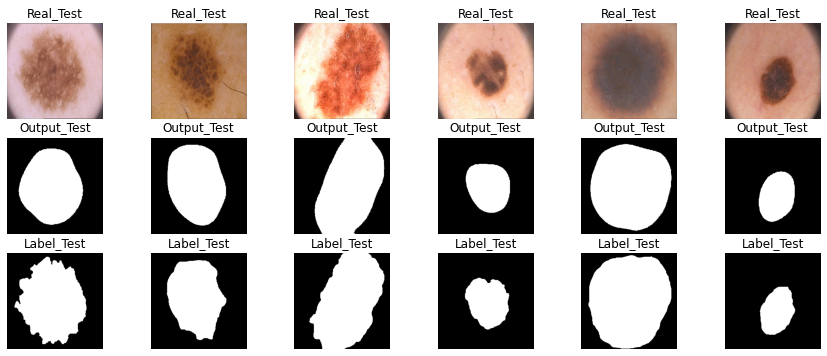

In [75]:
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

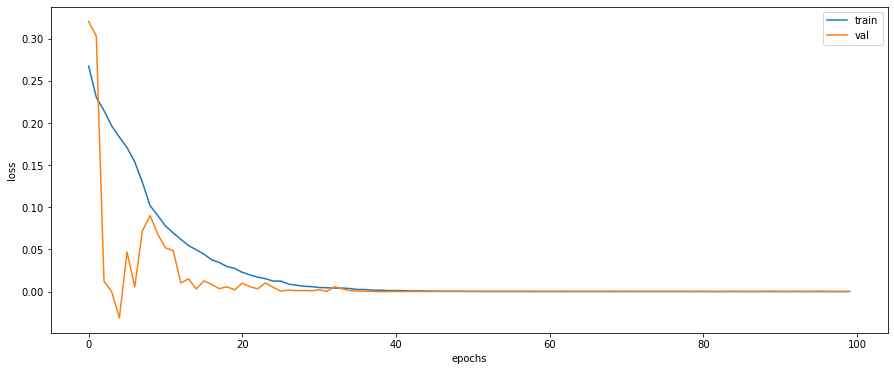

In [76]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

**Lovasz**

In [77]:
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss


def Lovasz(inputs, targets):
        inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz


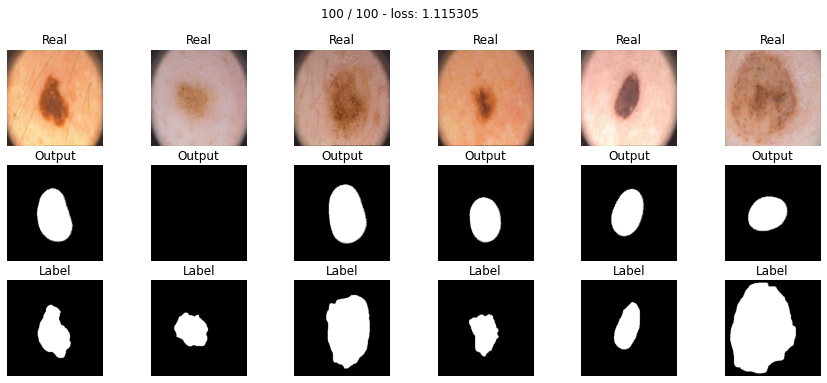

lr=1.0000000000000004e-08
score_max=0.7321636080741882
epoch_for_score_max=53


In [25]:
model = SegNet().to(device)
optimaizer= optim.Adam(model.parameters())
max_epochs = 100
PATH = "state_dict_best_model_segnet_Lovasz.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
Lovasz_segnet_train = train(model, optimaizer, Lovasz, max_epochs, data_tr, data_val, PATH)

score_for_val=0.7298948764801025
score_for_test=0.7464753687381744
epoch_for_score_max=53


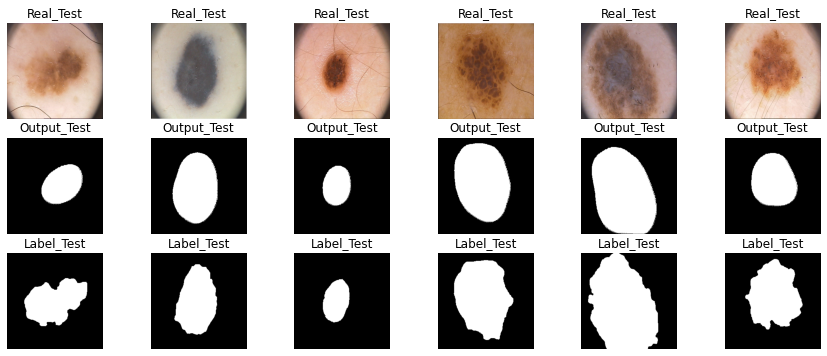

In [81]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
with open('Lovasz_segnet_train.pickle', 'wb') as f:
    pickle.dump(Lovasz_segnet_train, f)
    
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('Lovasz_segnet_train.pickle', 'rb') as f:
    Lovasz_segnet_train = pickle.load(f)
    
# Загрузим сохраненную лучшую модель 
model_segnet_Lovasz = SegNet()
model_segnet_Lovasz = model_segnet_Lovasz.to(device)
model_segnet_Lovasz.load_state_dict(torch.load("state_dict_best_model_segnet_Lovasz.pt"))

train_loss, val_loss, val_score, score_max, epoch_for_score_max = Lovasz_segnet_train

# Результаты score на валидационных данных
print(f'score_for_val={score_model(model_segnet_Lovasz, iou_pytorch, data_val)}')

# Результаты score на тестовых данных
print(f'score_for_test={score_model(model_segnet_Lovasz, iou_pytorch, data_ts)}')

# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

# Визуализируем прдсказания по тестовым данным
YYY = predict(model_segnet_Lovasz, data_ts)

for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

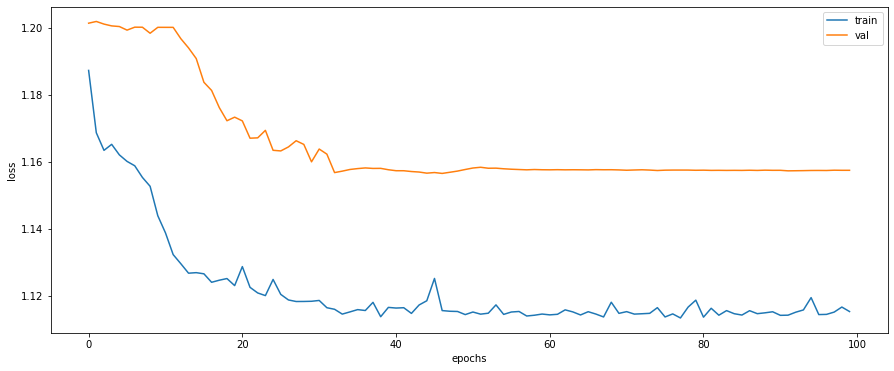

In [82]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

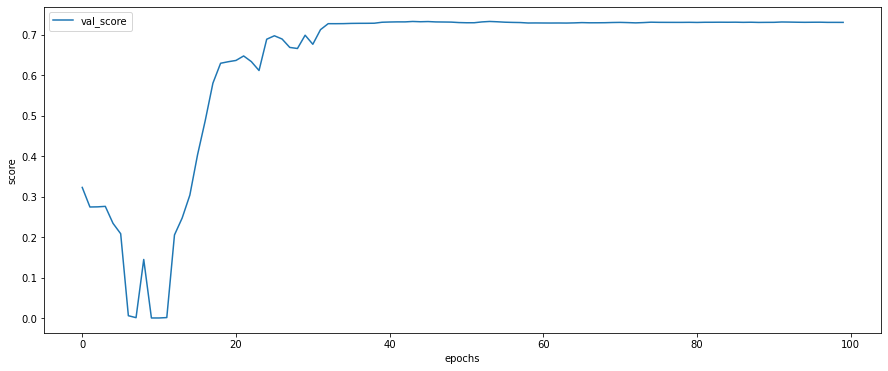

In [83]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

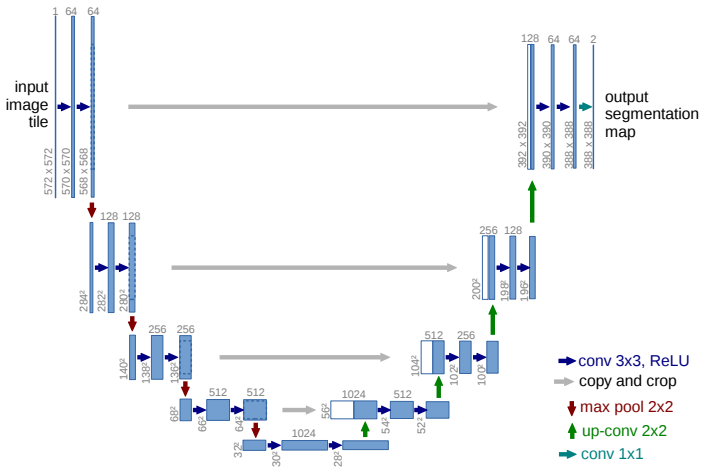

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [30]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = dual_conv(3, 64)
        self.enc_conv1 = dual_conv(64, 128)
        self.enc_conv2 = dual_conv(128, 256)
        self.enc_conv3 = dual_conv(256, 512)
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_enc_conv = dual_conv(512, 1024)      
        self.bottleneck_upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)

        # decoder (upsampling)
        self.dec_conv0 = dual_conv(1024,512)
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)        
        self.dec_conv1 = dual_conv(512, 256)
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)      
        self.dec_conv2 = dual_conv(256,128)
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)      
        self.dec_conv3 = dual_conv(128,64)               
        self.out = nn.Sequential(nn.Conv2d(64, 1, kernel_size=1, bias=False)) # no activation
  
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)  #
        #print(f'e0={e0.shape}')
        e1 = self.maxpool_2x2(e0)                           
        e2 = self.enc_conv1(e1) #
        e3 = self.maxpool_2x2(e2)                      
        e4 = self.enc_conv2(e3) #
        e5 = self.maxpool_2x2(e4)                           
        e6 = self.enc_conv3(e5) #
        e7 = self.maxpool_2x2(e6)
                
        # bottleneck
        e8 = self.bottleneck_enc_conv(e7)
        d0 = self.bottleneck_upsample(e8)
        
        # decoder
        d1 = self.dec_conv0(torch.cat([d0, e6], 1))
        d2 = self.upsample0(d1)
        d3 = self.dec_conv1(torch.cat([d2, e4], 1))
        d4 = self.upsample1(d3)        
        d5 = self.dec_conv2(torch.cat([d4, e2], 1))
        d6 = self.upsample2(d4)
        #print(f'd6={d6.shape}')
        d7 = self.dec_conv3(torch.cat([d6, e0], 1))
        d8 = self.out(d7)
        return d8
    
    
#if __name__ == "__main__":
#    x = torch.rand((1, 3, 256, 256))
#    model = UNet()
#    print(model(x))

#### bce_loss

In [ ]:
#model = UNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_unet_bce.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#bce_unet_train = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val, PATH)

score_for_val=0.8644163608551025
score_for_test=0.8688478469848633
epoch_for_score_max=73


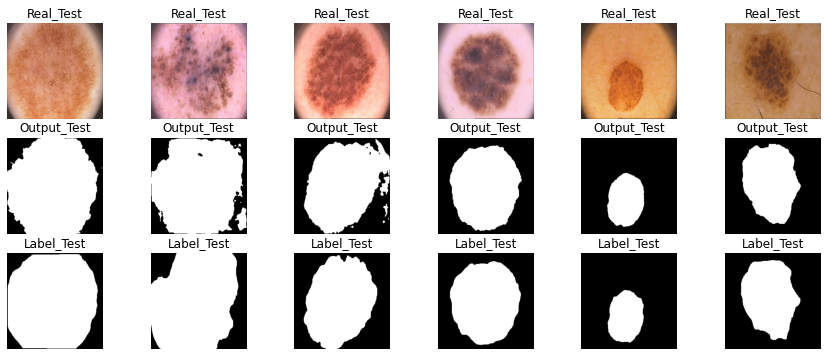

In [84]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
# with open('bce_unet_train.pickle', 'wb') as f:
#     pickle.dump(bce_unet_train, f)
    
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('bce_unet_train.pickle', 'rb') as f:
    bce_unet_train = pickle.load(f)
    
# Загрузим сохраненную лучшую модель 
model_unet_bce = UNet()
model_unet_bce = model_unet_bce.to(device)
model_unet_bce.load_state_dict(torch.load("state_dict_best_model_unet_bce.pt"))

train_loss, val_loss, val_score, score_max, epoch_for_score_max = bce_unet_train

# Результаты score на валидационных данных
print(f'score_for_val={score_model(model_unet_bce, iou_pytorch, data_val)}')

# Результаты score на тестовых данных
print(f'score_for_test={score_model(model_unet_bce, iou_pytorch, data_ts)}')

# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

# Визуализируем прдсказания по тестовым данным
YYY = predict(model_unet_bce, data_ts)

for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

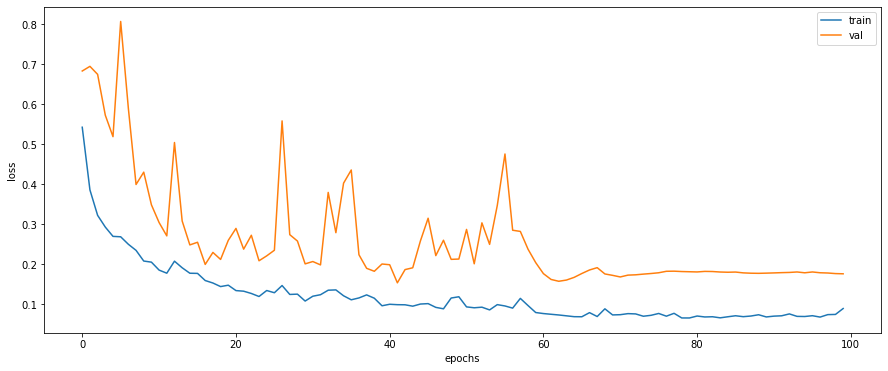

In [85]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

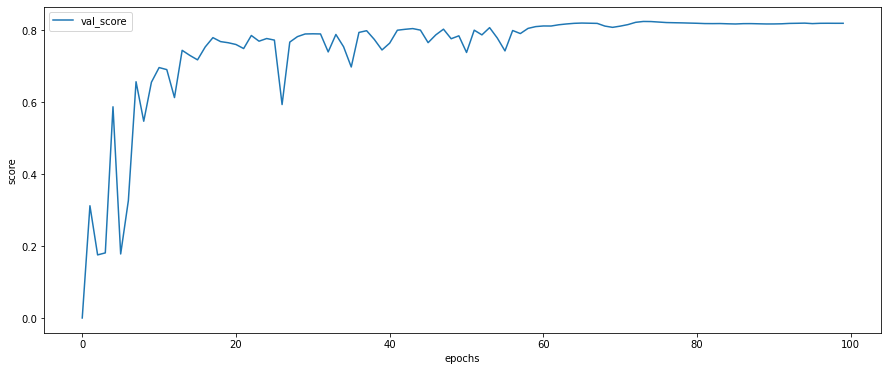

In [86]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

#### dice_loss

In [ ]:
#model = UNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_unet_dice.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#dice_unet_train = train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val, PATH)

score_for_val=0.5527699887752533
score_for_test=0.5667068958282471
epoch_for_score_max=24


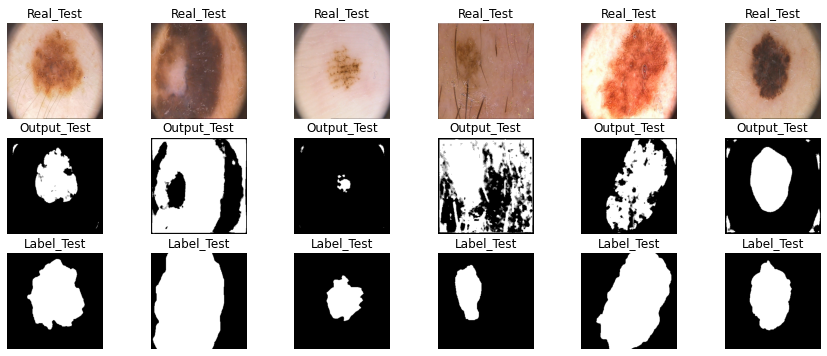

In [37]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
# with open('dice_unet_train.pickle', 'wb') as f:
#     pickle.dump(dice_unet_train, f)
    
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('dice_unet_train.pickle', 'rb') as f:
    dice_unet_train = pickle.load(f)
    
# Загрузим сохраненную лучшую модель 
model_unet_dice = UNet()
model_unet_dice = model_unet_dice.to(device)
model_unet_dice.load_state_dict(torch.load("state_dict_best_model_unet_dice.pt"))

train_loss, val_loss, val_score, score_max, epoch_for_score_max = dice_unet_train

# Результаты score на валидационных данных
print(f'score_for_val={score_model(model_unet_dice, iou_pytorch, data_val)}')

# Результаты score на тестовых данных
print(f'score_for_test={score_model(model_unet_dice, iou_pytorch, data_ts)}')

# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

# Визуализируем прдсказания по тестовым данным
YYY = predict(model_unet_dice, data_ts)

for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

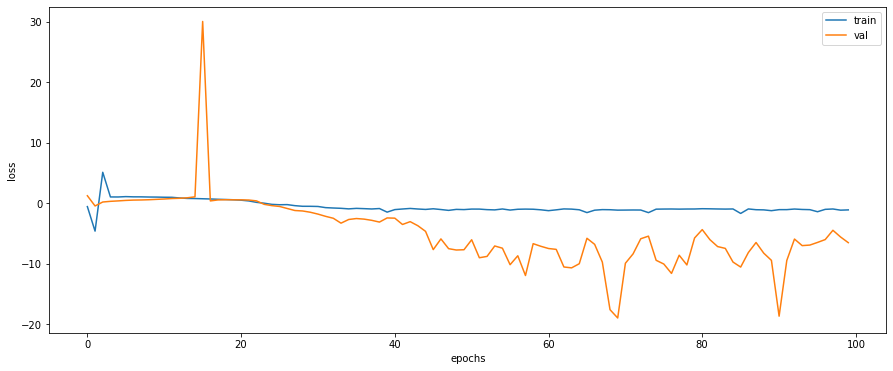

In [35]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

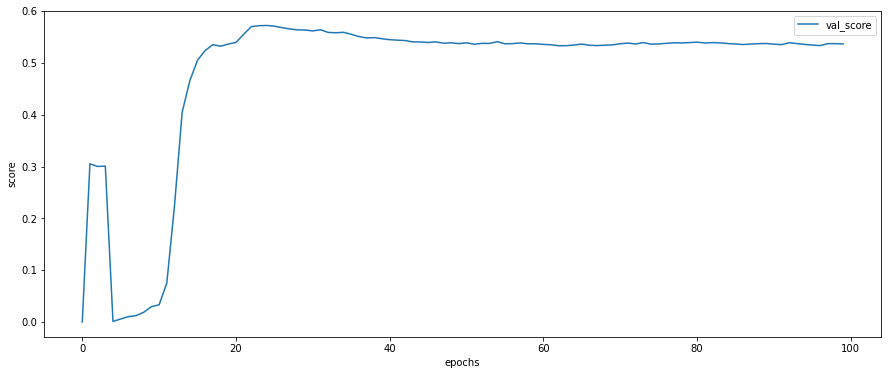

In [36]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

#### focal_loss

In [ ]:
#model = UNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_unet_focal.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#focal_unet_train = train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val, PATH)

score_for_val=0.26672427356243134
score_for_test=0.3165317252278328
epoch_for_score_max=68


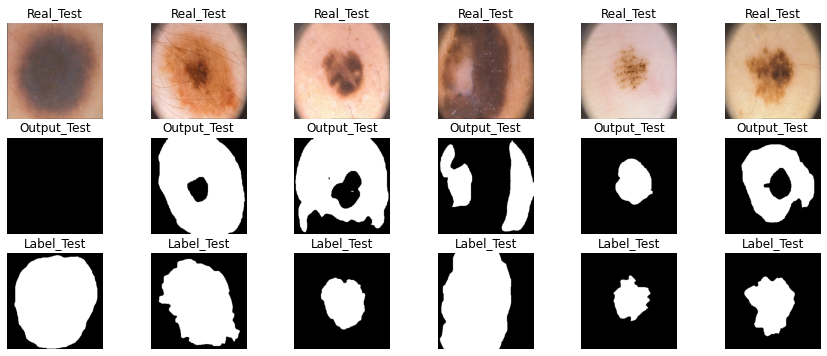

In [87]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
# with open('focal_unet_train.pickle', 'wb') as f:
#     pickle.dump(focal_unet_train, f)
    
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('focal_unet_train.pickle', 'rb') as f:
    focal_unet_train = pickle.load(f)
    
# Загрузим сохраненную лучшую модель 
model_unet_focal = UNet()
model_unet_focal = model_unet_focal.to(device)
model_unet_focal.load_state_dict(torch.load("state_dict_best_model_unet_focal.pt"))

train_loss, val_loss, val_score, score_max, epoch_for_score_max = focal_unet_train

# Результаты score на валидационных данных
print(f'score_for_val={score_model(model_unet_focal, iou_pytorch, data_val)}')

# Результаты score на тестовых данных
print(f'score_for_test={score_model(model_unet_focal, iou_pytorch, data_ts)}')

# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

# Визуализируем прдсказания по тестовым данным
YYY = predict(model_unet_focal, data_ts)

for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

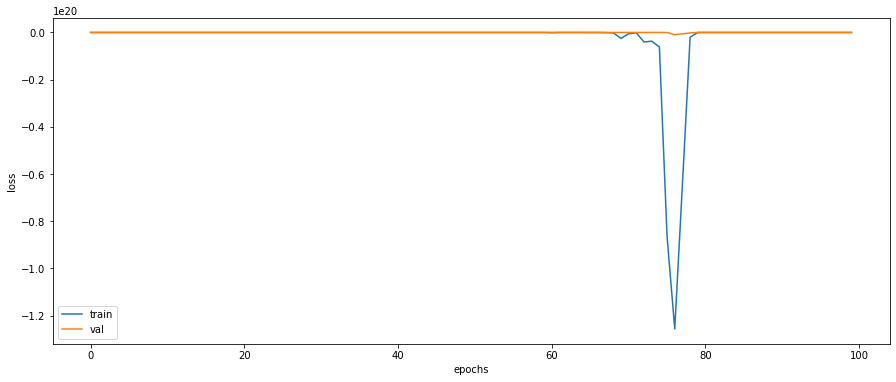

In [39]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

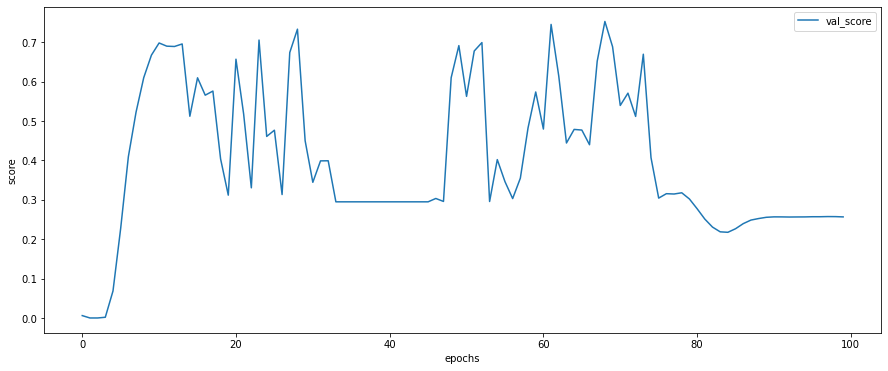

In [40]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

#### Lovasz_loss

In [ ]:
#model = UNet().to(device)
#optimaizer= optim.Adam(model.parameters())
#max_epochs = 100
#PATH = "state_dict_best_model_unet_Lovasz.pt"  # сохраним модель с наибольшим score (epoch)  на валидационных данных
#Lovasz_unet_train = train(model, optimaizer, Lovasz, max_epochs, data_tr, data_val, PATH)

score_for_val=0.8451778590679169
score_for_test=0.8235019743442535
epoch_for_score_max=50


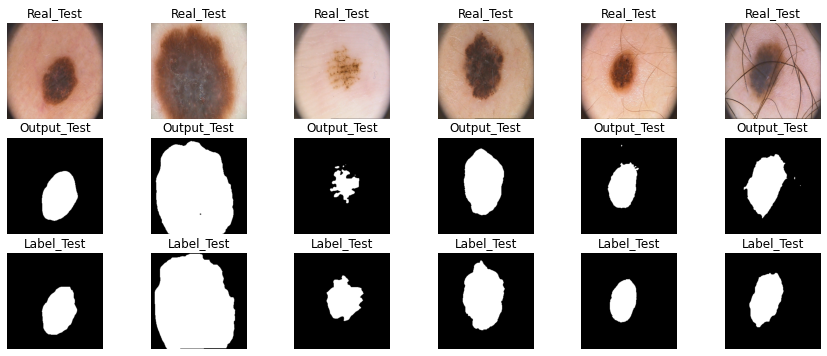

In [88]:
# Запишем данные для дальнейшей обработки, т.к. придется перезагружать ядра для других лоссов/моделей
# with open('Lovasz_unet_train.pickle', 'wb') as f:
#     pickle.dump(Lovasz_unet_train, f)
    
# Загрузим данные для дальнейшей обработки, ктр сохраняли для различных лоссов/моделей
with open('Lovasz_unet_train.pickle', 'rb') as f:
    Lovasz_unet_train = pickle.load(f)
    
# Загрузим сохраненную лучшую модель 
model_unet_Lovasz = UNet()
model_unet_Lovasz = model_unet_Lovasz.to(device)
model_unet_Lovasz.load_state_dict(torch.load("state_dict_best_model_unet_Lovasz.pt"))

train_loss, val_loss, val_score, score_max, epoch_for_score_max = Lovasz_unet_train

# Результаты score на валидационных данных
print(f'score_for_val={score_model(model_unet_Lovasz, iou_pytorch, data_val)}')

# Результаты score на тестовых данных
print(f'score_for_test={score_model(model_unet_Lovasz, iou_pytorch, data_ts)}')

# Результаты epoch_for_score_max
print(f'epoch_for_score_max={epoch_for_score_max }')

# Визуализируем прдсказания по тестовым данным
YYY = predict(model_unet_Lovasz, data_ts)

for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(YYY[1][k].numpy(), 0, 3), cmap='gray')
    plt.title('Real_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+7)
    plt.imshow(YYY[0][k, 0], cmap='gray')
    plt.title('Output_Test')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(YYY[2][k, 0].round(), cmap='gray')
    plt.title('Label_Test')
    plt.axis('off')

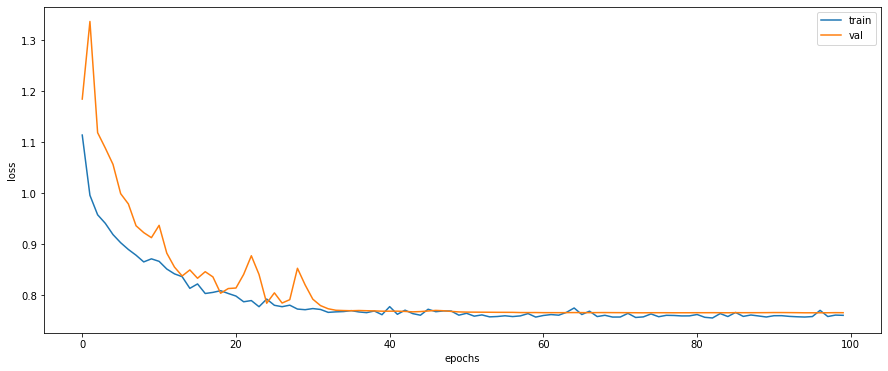

In [46]:
# Посомтрим как менялись loss для train и val в зависимости от эпох
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

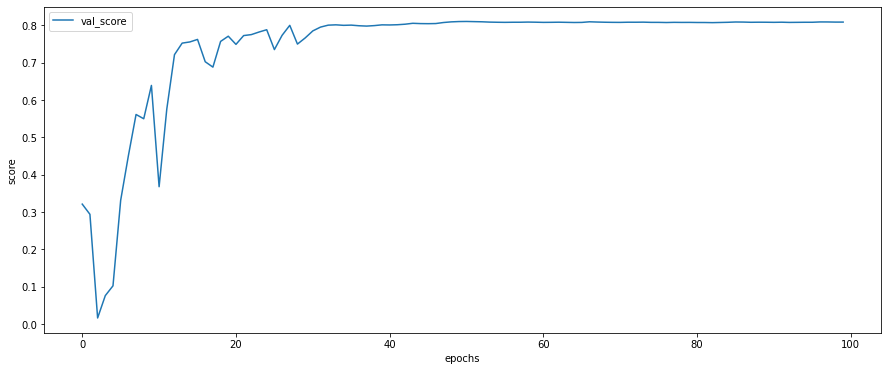

In [47]:
# Посомтрим как менялись val_score  в зависимости от эпох
plt.plot(val_score, label="val_score")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 


Провел 8 испытаний различных архитектур сетей.
    4 сетки с архитектурой SegNet и 4 сетки с архитектурой UNet на различных лоссах.
    Использовались лоссы: bce, dice, focal и Lovasz
    Шаг изменения Lr задавал с помощью ReduceLROnPlateau.
    Данные, ктр мы получили из обучения видны в текстовом и графическом визуализационном описании к каждому испытанию
    (более подробно писать нет времени, уже 23.40 18.05.2021)
    Если кртако, то наилучших показателей добились с Unet с лоссом bce и количесвтом эпох 73:
    
score_for_val=0.8644163608551025
score_for_test=0.8688478469848633
epoch_for_score_max=73

p.s. Прошу не снижать мне балл, т.к. проделал ОГРОМНУЮ работу и банально нет времени все описать !!!

p.s.s. СЕТЬ UNET СДЕЛАЛ ПО КЛАССИЧЕСКОЙ АРХИТЕКТУРЕ, SEGNET НЕМНОГО ПРОЯВИЛ ДОПОЛНИТЕЛЬНОЙ ФАНТАЗИИ))